<!--BOOK_INFORMATION-->

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

*No changes were made to the contents of this notebook from the original.*

# Aggregation and Grouping

An essential piece of analysis of large data is efficient summarization: computing aggregations like ``sum()``, ``mean()``, ``median()``, ``min()``, and ``max()``, in which a single number gives insight into the nature of a potentially large dataset.
In this section, we'll explore aggregations in Pandas, from simple operations akin to what we've seen on NumPy arrays, to more sophisticated operations based on the concept of a ``groupby``.

For convenience, we'll use the same ``display`` magic function that we've seen in previous sections:

In [1]:
import numpy as np
import pandas as pd

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

## Planets Data

Here we will use the Planets dataset, available via the [Seaborn package](http://seaborn.pydata.org/) (see [Visualization With Seaborn](04.14-Visualization-With-Seaborn.ipynb)).
It gives information on planets that astronomers have discovered around other stars (known as *extrasolar planets* or *exoplanets* for short). It can be downloaded with a simple Seaborn command:

In [2]:
import seaborn as sns
planets = sns.load_dataset('planets')
planets.shape

(1035, 6)

This has some details on the 1,000+ extrasolar planets discovered up to 2014.

In [3]:
planets.head(10)

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009
5,Radial Velocity,1,185.840,4.80,76.39,2008
6,Radial Velocity,1,1773.400,4.64,18.15,2002
7,Radial Velocity,1,798.500,NaN,21.41,1996
8,Radial Velocity,1,993.300,10.30,73.10,2008
9,Radial Velocity,2,452.800,1.99,74.79,2010


In [5]:
planets['method'].unique()

array(['Radial Velocity', 'Imaging', 'Eclipse Timing Variations',
       'Transit', 'Astrometry', 'Transit Timing Variations',
       'Orbital Brightness Modulation', 'Microlensing', 'Pulsar Timing',
       'Pulsation Timing Variations'], dtype=object)

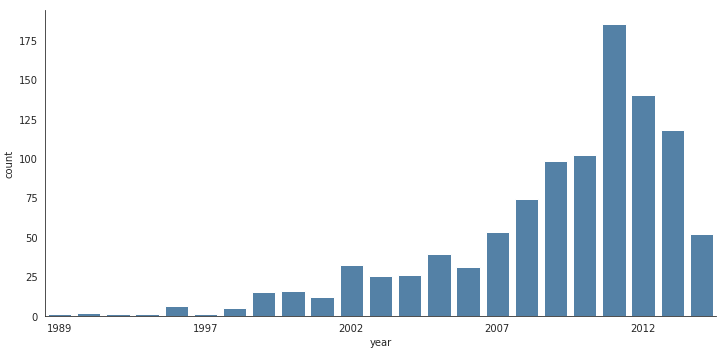

In [6]:
with sns.axes_style('white'):
    g = sns.catplot("year", data=planets, aspect=2,
                       kind="count", color='steelblue')
    g.set_xticklabels(step=5)

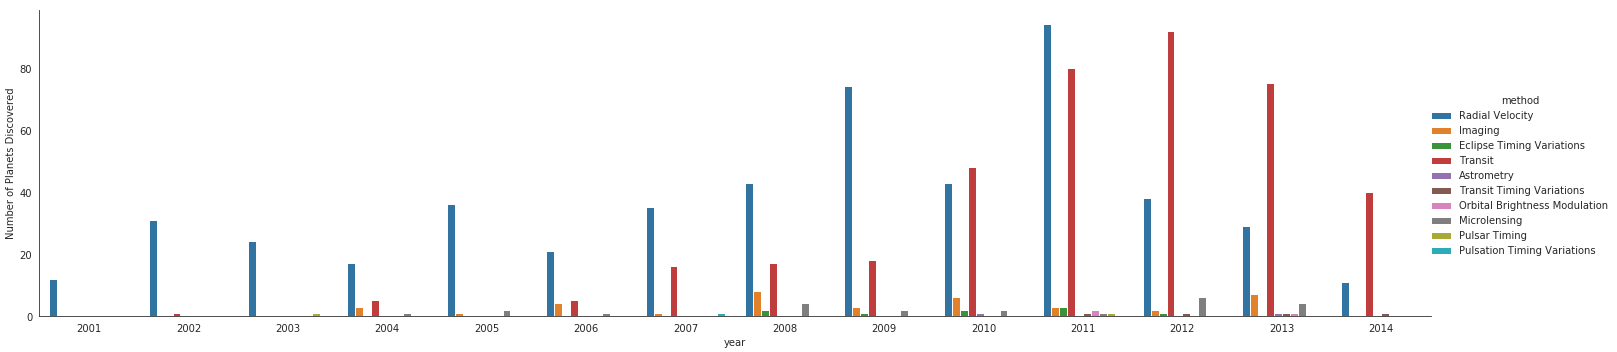

In [7]:
with sns.axes_style('white'):
    g = sns.catplot("year", data=planets, aspect=4.0, kind='count',
                       hue='method', order=range(2001, 2015))
    g.set_ylabels('Number of Planets Discovered')

## Simple Aggregation in Pandas

Earlier, we explored some of the data aggregations available for NumPy arrays (["Aggregations: Min, Max, and Everything In Between"](02.04-Computation-on-arrays-aggregates.ipynb)).
As with a one-dimensional NumPy array, for a Pandas ``Series`` the aggregates return a single value:

In [8]:
rng = np.random.RandomState(42)
ser = pd.Series(rng.rand(5))
ser

0    0.374540
1    0.950714
2    0.731994
3    0.598658
4    0.156019
dtype: float64

In [9]:
ser.sum()

2.811925491708157

In [10]:
ser.mean()

0.5623850983416314

For a ``DataFrame``, by default the aggregates return results within each column:

In [14]:
df = pd.DataFrame({'A': rng.rand(5),
                   'B': rng.rand(5),
                   'C': rng.rand(5)})
df

,A,B,C
0,0.183405,0.611853,0.785176
1,0.304242,0.139494,0.199674
2,0.524756,0.292145,0.514234
3,0.431945,0.366362,0.592415
4,0.291229,0.456070,0.046450


In [15]:
df.mean()

A    0.347115
B    0.373185
C    0.427590
dtype: float64

By specifying the ``axis`` argument, you can instead aggregate within each row:

In [13]:
df.mean(axis='columns')

0    0.088290
1    0.513997
2    0.849309
3    0.406727
4    0.444949
dtype: float64

Pandas ``Series`` and ``DataFrame``s include all of the common aggregates mentioned in [Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb); in addition, there is a convenience method ``describe()`` that computes several common aggregates for each column and returns the result.
Let's use this on the Planets data, for now dropping rows with missing values:

In [16]:
planets.dropna().describe()

,number,orbital_period,mass,distance,year
count,498.00000,498.000000,498.000000,498.000000,498.000000
mean,1.73494,835.778671,2.509320,52.068213,2007.377510
std,1.17572,1469.128259,3.636274,46.596041,4.167284
min,1.00000,1.328300,0.003600,1.350000,1989.000000
25%,1.00000,38.272250,0.212500,24.497500,2005.000000
50%,1.00000,357.000000,1.245000,39.940000,2009.000000
75%,2.00000,999.600000,2.867500,59.332500,2011.000000
max,6.00000,17337.500000,25.000000,354.000000,2014.000000


This can be a useful way to begin understanding the overall properties of a dataset.
For example, we see in the ``year`` column that although exoplanets were discovered as far back as 1989, half of all known expolanets were not discovered until 2010 or after.
This is largely thanks to the *Kepler* mission, which is a space-based telescope specifically designed for finding eclipsing planets around other stars.

The following table summarizes some other built-in Pandas aggregations:

| Aggregation              | Description                     |
|--------------------------|---------------------------------|
| ``count()``              | Total number of items           |
| ``first()``, ``last()``  | First and last item             |
| ``mean()``, ``median()`` | Mean and median                 |
| ``min()``, ``max()``     | Minimum and maximum             |
| ``std()``, ``var()``     | Standard deviation and variance |
| ``mad()``                | Mean absolute deviation         |
| ``prod()``               | Product of all items            |
| ``sum()``                | Sum of all items                |

These are all methods of ``DataFrame`` and ``Series`` objects.

To go deeper into the data, however, simple aggregates are often not enough.
The next level of data summarization is the ``groupby`` operation, which allows you to quickly and efficiently compute aggregates on subsets of data.

## GroupBy: Split, Apply, Combine

Simple aggregations can give you a flavor of your dataset, but often we would prefer to aggregate conditionally on some label or index: this is implemented in the so-called ``groupby`` operation.
The name "group by" comes from a command in the SQL database language, but it is perhaps more illuminative to think of it in the terms first coined by Hadley Wickham of Rstats fame: *split, apply, combine*.

### Split, apply, combine

A canonical example of this split-apply-combine operation, where the "apply" is a summation aggregation, is illustrated in this figure:

![split apply combine](https://cdn-images-1.medium.com/max/1600/1*w2oGdXv5btEMxAkAsz8fbg.png)
[figure source in Appendix](06.00-Figure-Code.ipynb#Split-Apply-Combine)

This makes clear what the ``groupby`` accomplishes:

- The *split* step involves breaking up and grouping a ``DataFrame`` depending on the value of the specified key.
- The *apply* step involves computing some function, usually an aggregate, transformation, or filtering, within the individual groups.
- The *combine* step merges the results of these operations into an output array.

While this could certainly be done manually using some combination of the masking, aggregation, and merging commands covered earlier, an important realization is that *the intermediate splits do not need to be explicitly instantiated*. Rather, the ``GroupBy`` can (often) do this in a single pass over the data, updating the sum, mean, count, min, or other aggregate for each group along the way.
The power of the ``GroupBy`` is that it abstracts away these steps: the user need not think about *how* the computation is done under the hood, but rather thinks about the *operation as a whole*.

As a concrete example, let's take a look at using Pandas for the computation shown in this diagram.
We'll start by creating the input ``DataFrame``:

In [18]:
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data': range(6)}, columns=['key', 'data'])
df

,key,data
0,A,0
1,B,1
2,C,2
3,A,3
4,B,4
5,C,5


The most basic split-apply-combine operation can be computed with the ``groupby()`` method of ``DataFrame``s, passing the name of the desired key column:

In [19]:
df

,key,data
0,A,0
1,B,1
2,C,2
3,A,3
4,B,4
5,C,5


In [20]:
grouped = df.groupby('key')

Notice that what is returned is not a set of ``DataFrame``s, but a ``DataFrameGroupBy`` object.
This object is where the magic is: you can think of it as a special view of the ``DataFrame``, which is poised to dig into the groups but does no actual computation until the aggregation is applied.
This "lazy evaluation" approach means that common aggregates can be implemented very efficiently in a way that is almost transparent to the user.

To produce a result, we can apply an aggregate to this ``DataFrameGroupBy`` object, which will perform the appropriate apply/combine steps to produce the desired result:

In [21]:
grouped.sum()

,data
key,
A,3
B,5
C,7


The ``sum()`` method is just one possibility here; you can apply virtually any common Pandas or NumPy aggregation function, as well as virtually any valid ``DataFrame`` operation, as we will see in the following discussion.

### The GroupBy object

The ``GroupBy`` object is a very flexible abstraction.
In many ways, you can simply treat it as if it's a collection of ``DataFrame``s, and it does the difficult things under the hood. Let's see some examples using the Planets data.

Perhaps the most important operations made available by a ``GroupBy`` are *aggregate*, *filter*, *transform*, and *apply*.
We'll discuss each of these more fully in ["Aggregate, Filter, Transform, Apply"](#Aggregate,-Filter,-Transform,-Apply), but before that let's introduce some of the other functionality that can be used with the basic ``GroupBy`` operation.

#### Column indexing

The ``GroupBy`` object supports column indexing in the same way as the ``DataFrame``, and returns a modified ``GroupBy`` object.
For example:

In [22]:
planets.columns

Index(['method', 'number', 'orbital_period', 'mass', 'distance', 'year'], dtype='object')

In [23]:
planets.groupby('method')

In [24]:
planets.groupby('method')['orbital_period']

Here we've selected a particular ``Series`` group from the original ``DataFrame`` group by reference to its column name.
As with the ``GroupBy`` object, no computation is done until we call some aggregate on the object:

In [25]:
planets[planets['year']==2000].groupby('method').mean()

,number,orbital_period,mass,distance,year
method,,,,,
Radial Velocity,1.6875,540.945323,3.633014,30.7525,2000.0


In [26]:
planets.groupby('year')['orbital_period'].sum()

year
1989        83.888000
1992        91.803900
1994        98.211400
1995         4.230785
1996      2015.769933
1997        39.845000
1998       571.553306
1999      8284.213789
2000      8655.125170
2001      8823.652700
2002     31098.693942
2003     54550.912880
2004     11836.848236
2005     28195.315999
2006    749338.718705
2007     18915.474897
2008    648234.382394
2009    129256.581285
2010     64276.094943
2011    130082.081196
2012     62840.010462
2013     14256.811931
2014     15344.034471
Name: orbital_period, dtype: float64

This gives an idea of the general scale of orbital periods (in days) that each method is sensitive to.

#### Iteration over groups

The ``GroupBy`` object supports direct iteration over the groups, returning each group as a ``Series`` or ``DataFrame``:

In [17]:
for (method, group) in planets.groupby('method'):
    print("{0:30s} shape={1}".format(method, group.shape))

Astrometry                     shape=(2, 6)
Eclipse Timing Variations      shape=(9, 6)
Imaging                        shape=(38, 6)
Microlensing                   shape=(23, 6)
Orbital Brightness Modulation  shape=(3, 6)
Pulsar Timing                  shape=(5, 6)
Pulsation Timing Variations    shape=(1, 6)
Radial Velocity                shape=(553, 6)
Transit                        shape=(397, 6)
Transit Timing Variations      shape=(4, 6)


This can be useful for doing certain things manually, though it is often much faster to use the built-in ``apply`` functionality, which we will discuss momentarily.

#### Dispatch methods

Through some Python class magic, any method not explicitly implemented by the ``GroupBy`` object will be passed through and called on the groups, whether they are ``DataFrame`` or ``Series`` objects.
For example, you can use the ``describe()`` method of ``DataFrame``s to perform a set of aggregations that describe each group in the data:

In [27]:
planets.groupby('method').describe()

number                                           \
                               count      mean       std  min  25%  50%   75%   
method                                                                          
Astrometry                       2.0  1.000000  0.000000  1.0  1.0  1.0  1.00   
Eclipse Timing Variations        9.0  1.666667  0.500000  1.0  1.0  2.0  2.00   
Imaging                         38.0  1.315789  0.933035  1.0  1.0  1.0  1.00   
Microlensing                    23.0  1.173913  0.387553  1.0  1.0  1.0  1.00   
Orbital Brightness Modulation    3.0  1.666667  0.577350  1.0  1.5  2.0  2.00   
Pulsar Timing                    5.0  2.200000  1.095445  1.0  1.0  3.0  3.00   
Pulsation Timing Variations      1.0  1.000000       NaN  1.0  1.0  1.0  1.00   
Radial Velocity                553.0  1.721519  1.157141  1.0  1.0  1.0  2.00   
Transit                        397.0  1.954660  1.399119  1.0  1.0  1.0  2.00   
Transit Timing Variations        4.0  2.250000  0.500000  2.0  2.0  2.0  2.25   

                                   orbital_period                 ...  \
                               max          count           mean  ...   
method                                                            ...   
Astrometry                     1.0            2.0     631.180000  ...   
Eclipse Timing Variations      2.0            9.0    4751.644444  ...   
Imaging                        4.0           12.0  118247.737500  ...   
Microlensing                   2.0            7.0    3153.571429  ...   
Orbital Brightness Modulation  2.0            3.0       0.709307  ...   
Pulsar Timing                  3.0            5.0    7343.021201  ...   
Pulsation Timing Variations    1.0            1.0    1170.000000  ...   
Radial Velocity                6.0          553.0     823.354680  ...   
Transit                        7.0          397.0      21.102073  ...   
Transit Timing Variations      3.0            3.0      79.783500  ...   

                                distance            year               \
                                     75%      max  count         mean   
method                                                                  
Astrometry                       19.3225    20.77    2.0  2011.500000   
Eclipse Timing Variations       500.0000   500.00    9.0  2010.000000   
Imaging                         132.6975   165.00   38.0  2009.131579   
Microlensing                   4747.5000  7720.00   23.0  2009.782609   
Orbital Brightness Modulation  1180.0000  1180.00    3.0  2011.666667   
Pulsar Timing                  1200.0000  1200.00    5.0  1998.400000   
Pulsation Timing Variations          NaN      NaN    1.0  2007.000000   
Radial Velocity                  59.2175   354.00  553.0  2007.518987   
Transit                         650.0000  8500.00  397.0  2011.236776   
Transit Timing Variations      1487.0000  2119.00    4.0  2012.500000   

                                                                           \
                                    std     min      25%     50%      75%   
method                                                                      
Astrometry                     2.121320  2010.0  2010.75  2011.5  2012.25   
Eclipse Timing Variations      1.414214  2008.0  2009.00  2010.0  2011.00   
Imaging                        2.781901  2004.0  2008.00  2009.0  2011.00   
Microlensing                   2.859697  2004.0  2008.00  2010.0  2012.00   
Orbital Brightness Modulation  1.154701  2011.0  2011.00  2011.0  2012.00   
Pulsar Timing                  8.384510  1992.0  1992.00  1994.0  2003.00   
Pulsation Timing Variations         NaN  2007.0  2007.00  2007.0  2007.00   
Radial Velocity                4.249052  1989.0  2005.00  2009.0  2011.00   
Transit                        2.077867  2002.0  2010.00  2012.0  2013.00   
Transit Timing Variations      1.290994  2011.0  2011.75  2012.5  2013.25   

                                       
                                  

In [28]:
planets.groupby('method')['year'].describe()

,count,mean,std,min,25%,50%,75%,max
method,,,,,,,,
Astrometry,2.0,2011.500000,2.121320,2010.0,2010.75,2011.5,2012.25,2013.0
Eclipse Timing Variations,9.0,2010.000000,1.414214,2008.0,2009.00,2010.0,2011.00,2012.0
Imaging,38.0,2009.131579,2.781901,2004.0,2008.00,2009.0,2011.00,2013.0
Microlensing,23.0,2009.782609,2.859697,2004.0,2008.00,2010.0,2012.00,2013.0
Orbital Brightness Modulation,3.0,2011.666667,1.154701,2011.0,2011.00,2011.0,2012.00,2013.0
Pulsar Timing,5.0,1998.400000,8.384510,1992.0,1992.00,1994.0,2003.00,2011.0
Pulsation Timing Variations,1.0,2007.000000,NaN,2007.0,2007.00,2007.0,2007.00,2007.0
Radial Velocity,553.0,2007.518987,4.249052,1989.0,2005.00,2009.0,2011.00,2014.0
Transit,397.0,2011.236776,2.077867,2002.0,2010.00,2012.0,2013.00,2014.0


In [18]:
planets.groupby('method')['year'].describe().unstack()

       method                       
count  Astrometry                          2.000000
       Eclipse Timing Variations           9.000000
       Imaging                            38.000000
       Microlensing                       23.000000
       Orbital Brightness Modulation       3.000000
       Pulsar Timing                       5.000000
       Pulsation Timing Variations         1.000000
       Radial Velocity                   553.000000
       Transit                           397.000000
       Transit Timing Variations           4.000000
mean   Astrometry                       2011.500000
       Eclipse Timing Variations        2010.000000
       Imaging                          2009.131579
       Microlensing                     2009.782609
       Orbital Brightness Modulation    2011.666667
       Pulsar Timing                    1998.400000
       Pulsation Timing Variations      2007.000000
       Radial Velocity                  2007.518987
       Transit             

Looking at this table helps us to better understand the data: for example, the vast majority of planets have been discovered by the Radial Velocity and Transit methods, though the latter only became common (due to new, more accurate telescopes) in the last decade.
The newest methods seem to be Transit Timing Variation and Orbital Brightness Modulation, which were not used to discover a new planet until 2011.

This is just one example of the utility of dispatch methods.
Notice that they are applied *to each individual group*, and the results are then combined within ``GroupBy`` and returned.
Again, any valid ``DataFrame``/``Series`` method can be used on the corresponding ``GroupBy`` object, which allows for some very flexible and powerful operations!

### Aggregate, filter, transform, apply

The preceding discussion focused on aggregation for the combine operation, but there are more options available.
In particular, ``GroupBy`` objects have ``aggregate()``, ``filter()``, ``transform()``, and ``apply()`` methods that efficiently implement a variety of useful operations before combining the grouped data.

For the purpose of the following subsections, we'll use this ``DataFrame``:

In [54]:
rng = np.random.RandomState(0)
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data1': range(6),
                   'data2': rng.randint(0, 10, 6)},
                   columns = ['key', 'data1', 'data2'])
df

,key,data1,data2
0,A,0,5
1,B,1,0
2,C,2,3
3,A,3,3
4,B,4,7
5,C,5,9


#### Aggregation

We're now familiar with ``GroupBy`` aggregations with ``sum()``, ``median()``, and the like, but the ``aggregate()`` method allows for even more flexibility.
It can take a string, a function, or a list thereof, and compute all the aggregates at once.
Here is a quick example combining all these:

In [59]:
df.groupby('key').aggregate(['min', np.median, max])

data1            data2           
      min median max   min median max
key                                  
A       0    1.5   3     3    4.0   5
B       1    2.5   4     0    3.5   7
C       2    3.5   5     3    6.0   9

Another useful pattern is to pass a dictionary mapping column names to operations to be applied on that column:

In [61]:
df.groupby('key').aggregate({'data1': ['min', 'mean'],
                             'data2': 'max'})

data1      data2
      min mean   max
key                 
A       0  1.5     5
B       1  2.5     7
C       2  3.5     9

#### Filtering

A filtering operation allows you to drop data based on the group properties.
For example, we might want to keep all groups in which the standard deviation is larger than some critical value:

In [22]:
def filter_func(x):
    return x['data2'].std() > 4

display('df', "df.groupby('key').std()", "df.groupby('key').filter(filter_func)")

df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby('key').std()
       data1     data2
key                   
A    2.12132  1.414214
B    2.12132  4.949747
C    2.12132  4.242641

df.groupby('key').filter(filter_func)
  key  data1  data2
1   B      1      0
2   C      2      3
4   B      4      7
5   C      5      9

The filter function should return a Boolean value specifying whether the group passes the filtering. Here because group A does not have a standard deviation greater than 4, it is dropped from the result.

#### Transformation

While aggregation must return a reduced version of the data, transformation can return some transformed version of the full data to recombine.
For such a transformation, the output is the same shape as the input.
A common example is to center the data by subtracting the group-wise mean:

In [23]:
df.groupby('key').transform(lambda x: x - x.mean())

,data1,data2
0,-1.5,1.0
1,-1.5,-3.5
2,-1.5,-3.0
3,1.5,-1.0
4,1.5,3.5
5,1.5,3.0


#### The apply() method

The ``apply()`` method lets you apply an arbitrary function to the group results.
The function should take a ``DataFrame``, and return either a Pandas object (e.g., ``DataFrame``, ``Series``) or a scalar; the combine operation will be tailored to the type of output returned.

For example, here is an ``apply()`` that normalizes the first column by the sum of the second:

In [24]:
def norm_by_data2(x):
    # x is a DataFrame of group values
    x['data1'] /= x['data2'].sum()
    return x

display('df', "df.groupby('key').apply(norm_by_data2)")

,key,data1,data2
0,A,0,5
1,B,1,0
2,C,2,3
3,A,3,3
4,B,4,7
5,C,5,9
,key,data1,data2
0,A,0.000000,5
1,B,0.142857,0
2,C,0.166667,3


``apply()`` within a ``GroupBy`` is quite flexible: the only criterion is that the function takes a ``DataFrame`` and returns a Pandas object or scalar; what you do in the middle is up to you!

### Specifying the split key

In the simple examples presented before, we split the ``DataFrame`` on a single column name.
This is just one of many options by which the groups can be defined, and we'll go through some other options for group specification here.

#### A list, array, series, or index providing the grouping keys

The key can be any series or list with a length matching that of the ``DataFrame``. For example:

In [25]:
L = [0, 1, 0, 1, 2, 0]
display('df', 'df.groupby(L).sum()')

df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby(L).sum()
   data1  data2
0      7     17
1      4      3
2      4      7

Of course, this means there's another, more verbose way of accomplishing the ``df.groupby('key')`` from before:

In [26]:
display('df', "df.groupby(df['key']).sum()")

df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby(df['key']).sum()
     data1  data2
key              
A        3      8
B        5      7
C        7     12

#### A dictionary or series mapping index to group

Another method is to provide a dictionary that maps index values to the group keys:

In [27]:
df2 = df.set_index('key')
mapping = {'A': 'vowel', 'B': 'consonant', 'C': 'consonant'}
display('df2', 'df2.groupby(mapping).sum()')

,data1,data2
key,,
A,0,5
B,1,0
C,2,3
A,3,3
B,4,7
C,5,9
,data1,data2
consonant,12,19
vowel,3,8


#### Any Python function

Similar to mapping, you can pass any Python function that will input the index value and output the group:

In [28]:
display('df2', 'df2.groupby(str.lower).mean()')

,data1,data2
key,,
A,0,5
B,1,0
C,2,3
A,3,3
B,4,7
C,5,9
,data1,data2
a,1.5,4.0
b,2.5,3.5


#### A list of valid keys

Further, any of the preceding key choices can be combined to group on a multi-index:

In [29]:
df2.groupby([str.lower, mapping]).mean()

,,data1,data2
a,vowel,1.5,4.0
b,consonant,2.5,3.5
c,consonant,3.5,6.0


### Grouping example

As an example of this, in a couple lines of Python code we can put all these together and count discovered planets by method and by decade:

In [30]:
decade = 10 * (planets['year'] // 10)
decade = decade.astype(str) + 's'
decade.name = 'decade'
planets.groupby(['method', decade])['number'].sum().unstack().fillna(0)

decade,1980s,1990s,2000s,2010s
method,,,,
Astrometry,0.0,0.0,0.0,2.0
Eclipse Timing Variations,0.0,0.0,5.0,10.0
Imaging,0.0,0.0,29.0,21.0
Microlensing,0.0,0.0,12.0,15.0
Orbital Brightness Modulation,0.0,0.0,0.0,5.0
Pulsar Timing,0.0,9.0,1.0,1.0
Pulsation Timing Variations,0.0,0.0,1.0,0.0
Radial Velocity,1.0,52.0,475.0,424.0
Transit,0.0,0.0,64.0,712.0


This shows the power of combining many of the operations we've discussed up to this point when looking at realistic datasets.
We immediately gain a coarse understanding of when and how planets have been discovered over the past several decades!

Here I would suggest digging into these few lines of code, and evaluating the individual steps to make sure you understand exactly what they are doing to the result.
It's certainly a somewhat complicated example, but understanding these pieces will give you the means to similarly explore your own data.